# Research Manuscript Order

Questions
* No story ID appears more than once in a manuscript, correct?
* You're working with integers, but IDs are sometimes strings?

Todo
* Figure out how to turn CSVs into format shown in `test_manuscripts` below
* Make better categories for permutations (see "Can we categorize the different permutations?"
section)
* Migrate to Google Colab
    * Does Colab allow a user to git clone a repo when run?
* After confirming that current methods are appropriate, write "group by year" code.

In [15]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
test_manuscripts = [
    [1, 2, 3],
    [1, 2, 3, 4, 5],
    [2, 1, 4, 5, 10, 15],
    [10, 2, 4, 5, 6, 3, 7],
    [8, 9, 11, 2, 1],
    [1, 2, 3, 4, 5, 6, 8, 9, 10, 11], 
    [11, 2, 12, 8, 13, 15, 14]
]

all_manuscripts = []

for _ in range(1000):
    l = random.sample(test_manuscripts, k=1)[0]
    all_manuscripts.append(random.sample(l, k=len(l)))

all_ids = []
for man in all_manuscripts:
    all_ids.extend(man)
unique_ids = set(all_ids)
N = max(unique_ids)

## How often does each Story ID appear?

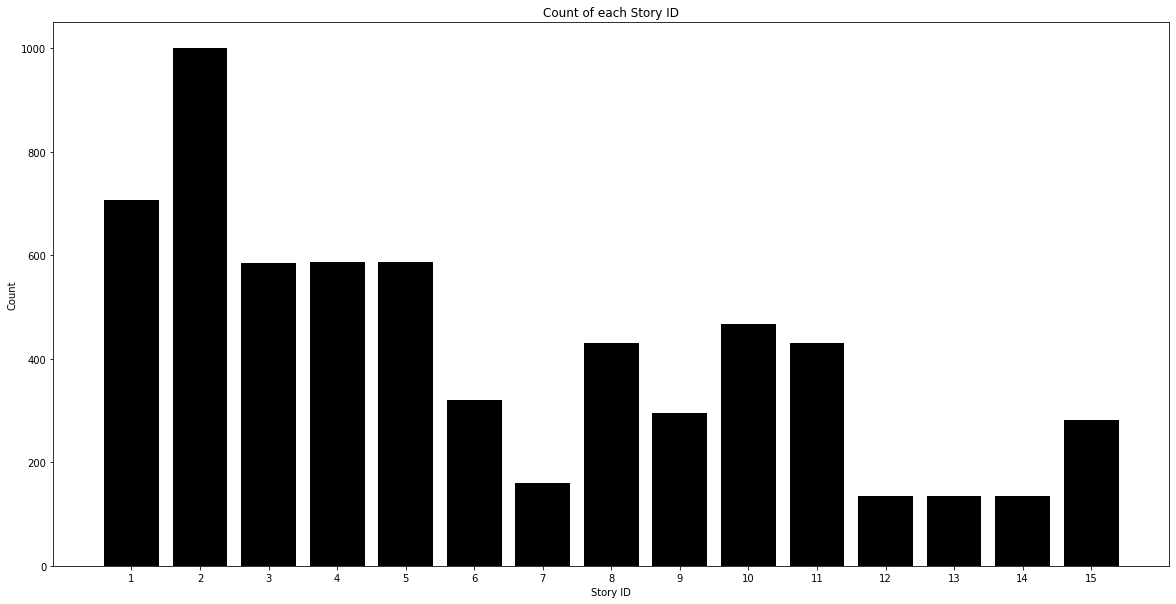

In [17]:
counts = {x: all_ids.count(x) for x in set(all_ids)}

plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), height=counts.values(), color="k")
plt.xticks(range(1, N+1))
plt.ylabel('Count')
plt.xlabel('Story ID')
plt.title('Count of each Story ID')
None

## What is the distribution of the Levenshtein edit distance?

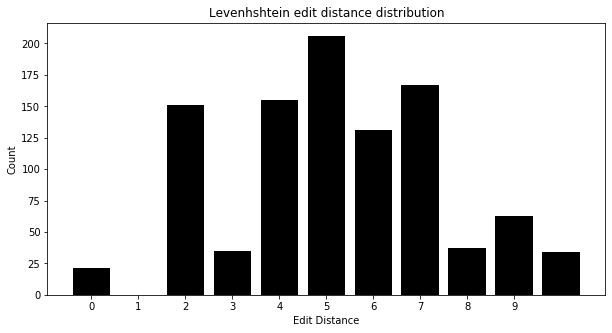

In [18]:
# make a histogram of all edit distances
def perfect(l):
    return list(range(1, len(l) + 1))

def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

ld = [levenshteinDistance(man, perfect(man)) for man in all_manuscripts]

ld_counts = {x: ld.count(x) for x in set(ld)}

plt.figure(figsize=(10, 5))
plt.bar(ld_counts.keys(), height=ld_counts.values(), color='k')
plt.title('Levenhshtein edit distance distribution')
plt.xlabel('Edit Distance')
plt.ylabel('Count')
plt.xticks(range(max(ld)))
None

## What are each Story ID's neighbors?

In [19]:
neighbor_d = {x: {'before': [], 'after': []} for x in unique_ids}
for man in all_manuscripts:
    for i, story_id in enumerate(man):
        if i == 0:
            neighbor_d[story_id]['before'].append('F')
            neighbor_d[story_id]['after'].append(man[i+1])
        elif i == len(man)-1:
            neighbor_d[story_id]['before'].append(man[i-1])
            neighbor_d[story_id]['after'].append('L')
        else:
            neighbor_d[story_id]['before'].append(man[i-1])
            neighbor_d[story_id]['after'].append(man[i+1])

In [20]:
def perc(map_dict, i, c):
    l = map_dict.get(i, [])
    return np.nan if len(l) == 0 else round(l.count(c)/len(l)*100, 2)

before_map = {x: d['before'] for x, d in neighbor_d.items()}
after_map = {x: d['after'] for x, d in neighbor_d.items()}

df_b = pd.DataFrame(columns=['F'] + list(range(1, N+1)), index=range(1, N+1))
for c in df_b.columns:
    df_b[c] = [perc(before_map, i, c) for i in df_b.index]

df_a = pd.DataFrame(columns=list(range(1, N+1)) + ['L'], index=range(1, N+1))
for c in df_a.columns:
    df_a[c] = [perc(after_map, i, c) for i in df_a.index]

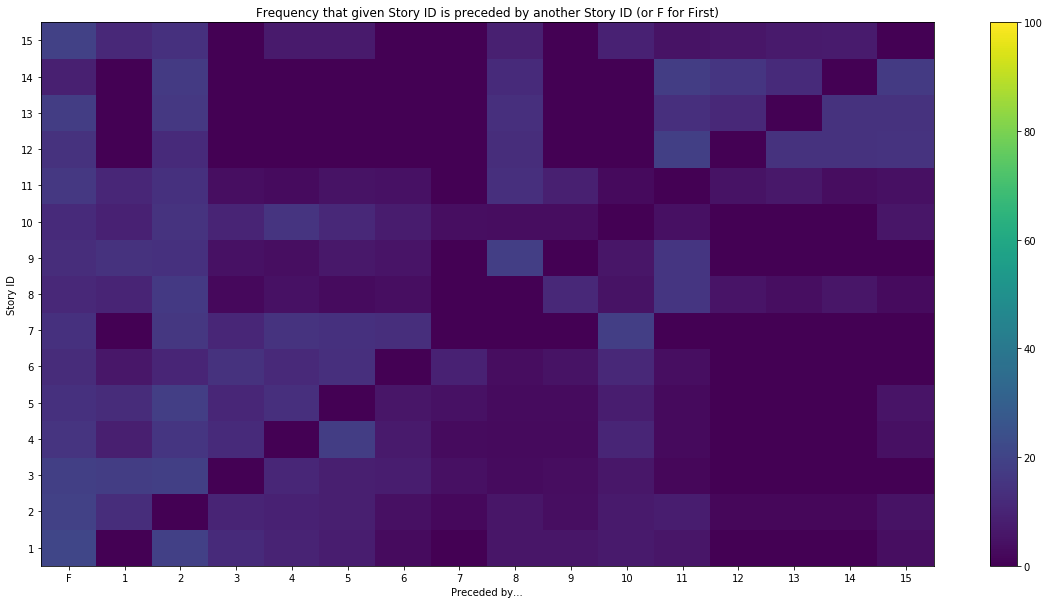

In [21]:
plt.figure(figsize=(20, 10)) 
plt.pcolor(df_b, vmin=0, vmax=100)
plt.yticks(np.arange(0.5, len(df_b.index), 1), df_b.index)
plt.xticks(np.arange(0.5, len(df_b.columns), 1), df_b.columns)
plt.ylabel('Story ID')
plt.xlabel('Preceded by...')
plt.colorbar()
plt.title('Frequency that given Story ID is preceded by another Story ID (or F for First)')
None

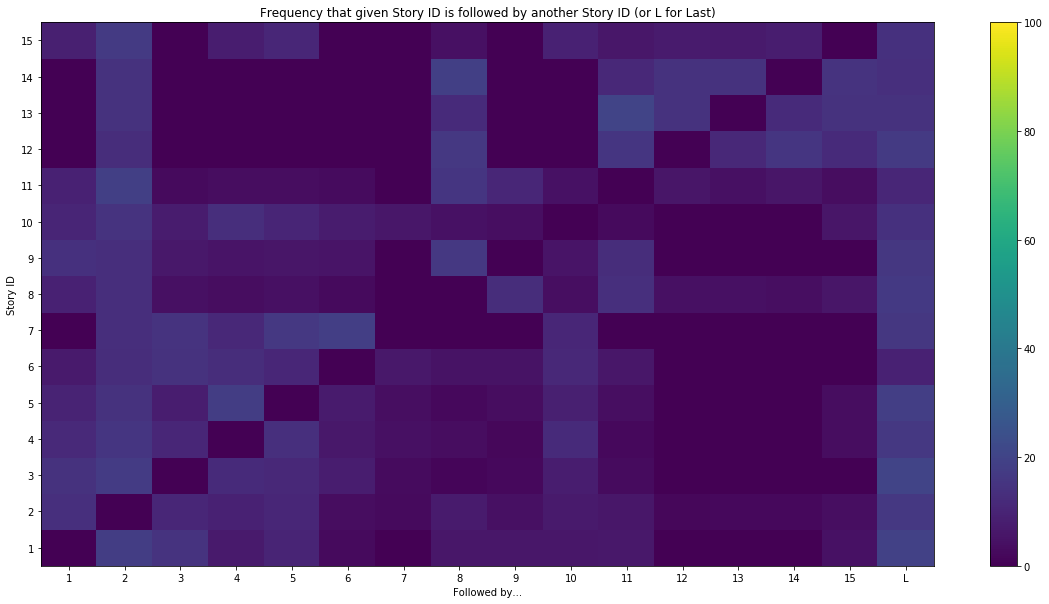

In [22]:
plt.figure(figsize=(20, 10)) 
plt.pcolor(df_a, vmin=0, vmax=100)
plt.yticks(np.arange(0.5, len(df_a.index), 1), df_a.index)
plt.xticks(np.arange(0.5, len(df_a.columns), 1), df_a.columns)
plt.xlabel('Followed by...')
plt.ylabel('Story ID')
plt.colorbar()
plt.title('Frequency that given Story ID is followed by another Story ID (or L for Last)')
None

## Can we categorize the different permutations?

In [23]:
def is_substitution(l):
    # e.g. 1-2-3-10-5
    return not all([x in perfect(l) for x in l])  

def is_sorted(l):
    # e.g. 1-2-3-10-15
    return (sorted(l) == l)

def is_reordered(l):
    # e.g. 1-2-3-5-4
    return sorted(l) == perfect(l)

def is_perfect(l):
    # e.g. 1-2-3-4-5
    return perfect(l) == l

def get_perc(j, func):
    return round(len([1 for man in j if func(man)])/len(j)*100, 2)

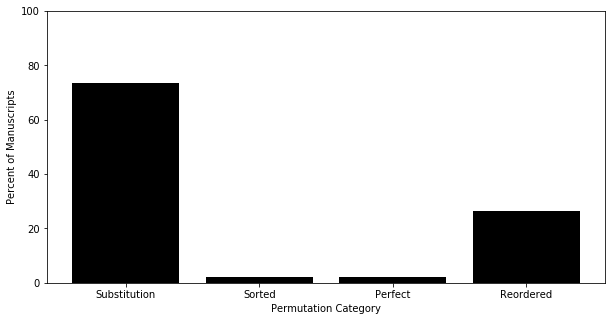

In [24]:
alteration_type = {
    'Substitution': get_perc(all_manuscripts, is_substitution),
    'Sorted': get_perc(all_manuscripts, is_sorted),
    'Perfect': get_perc(all_manuscripts, is_perfect),
    'Reordered': get_perc(all_manuscripts, is_reordered)
}

plt.figure(figsize=(10, 5))
plt.bar(alteration_type.keys(), alteration_type.values(), color='k')
plt.ylim((0, 100))
plt.xlabel('Permutation Category')
plt.ylabel('Percent of Manuscripts')

# sum(alteration_type.values())
None